<a href="https://colab.research.google.com/github/koad7/3d_vision/blob/main/ImageCaptioningWithoutAttention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Image captioning without using attention

https://www.kaggle.com/code/mdteach/image-captioning-with-out-attention-pytorch

Flickr dataset: https://www.kaggle.com/datasets/adityajn105/flickr8k


In [19]:
import os
import spacy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torchtext
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
import torchvision.models as models

from PIL import Image
from collections import Counter

from torchtext.vocab import vocab
from torchtext.data.utils import get_tokenizer

from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader

Mounting the Google drive for using the Data stored in Drive

In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


We are extracting the zipped image and caption files.

In [27]:
image_captions = pd.read_csv('/content/drive/MyDrive/AI/Ex_Files_Intro_to_Attention_Based_Neural_Networks/Exercise Files/flickr8k/captions.txt')

image_captions.sample(5)

,image,caption
20239,3106782647_b078830a9e.jpg,The teen jumps the hill with his bicycle .
26569,3370308329_7f2de5bb58.jpg,Four snowsuit clad children climb up a snowy h...
815,1184967930_9e29ce380d.jpg,A brown dog running through the grass and flow...
7171,2285741931_07159a21f2.jpg,A girl wearing a helmet rides a scooter .
15755,2861100960_457ceda7fa.jpg,A man wearing a straw hat smokes a cigarette .


In [28]:
image_captions.shape

(40455, 2)

In [29]:
image_captions['caption'].tolist()[:10]

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .',
 'A black dog and a spotted dog are fighting',
 'A black dog and a tri-colored dog playing with each other on the road .',
 'A black dog and a white dog with brown spots are staring at each other in the street .',
 'Two dogs of different breeds looking at each other on the road .',
 'Two dogs on pavement moving toward each other .']

Device is defined for acceleration of training

In [30]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

device

device(type='cuda', index=0)

Loading tokeniser from torchtext library and counter is instantiated

In [31]:
tokenizer = get_tokenizer('basic_english')

counter = Counter()

In [32]:
tokenizer('A black dog and a tri-colored dog playing with each other on the road .')

['a',
 'black',
 'dog',
 'and',
 'a',
 'tri-colored',
 'dog',
 'playing',
 'with',
 'each',
 'other',
 'on',
 'the',
 'road',
 '.']

We are building the vocabulary for captions using torchtext.

In [33]:
for line in image_captions['caption'].tolist():
    counter.update(tokenizer(line))

vocab = vocab(counter, min_freq = 5)

Special tokens are added and default index is set as UNK(Note that torchtext version in colab is 0.11.In latest version(0.12) we can simply add special tokens in vocab arguments itself)

In [34]:
unk_token = '<unk>'
pad_token = '<pad>'
sos_token = '<sos>'
eos_token = '<eos>'

vocab.insert_token(unk_token, 0)
vocab.insert_token(pad_token, 1)
vocab.insert_token(sos_token, 2)
vocab.insert_token(eos_token, 3)

vocab.set_default_index(vocab['<unk>'])

In [35]:
len(vocab)

3005

In [36]:
vocab['dog']

29

In [37]:
vocab['boy']

142

In [38]:
vocab[eos_token]

3

Dataset is defined and get_item method returns Images with their  captions tokens in integer form(token ids)

In [39]:
class FlickrDataset(Dataset):
   
    def __init__(self, root_dir, captions_file, vocab, transform = None):

        self.root_dir = root_dir
        self.transform = transform
        self.vocab = vocab               
        
        df = pd.read_csv(captions_file)

        self.length = len(df)

        self.captions = df['caption']
        self.img_names = df['image']
    
    def __len__(self):
        return self.length
    
    def __getitem__(self, idx):
        caption = self.captions[idx]
        img_name = self.img_names[idx]

        img_location = os.path.join(self.root_dir, img_name)
        img = Image.open(img_location).convert('RGB')
        
        if self.transform is not None:
            img = self.transform(img)

        caption_text_to_index = lambda x: [self.vocab[token] for token in tokenizer(x)]

        caption_vec = []
        caption_vec += [vocab['<sos>']]
        caption_vec +=  caption_text_to_index(caption)
        caption_vec += [vocab['<eos>']]
        
        return img, torch.tensor(caption_vec)

Data collation in the form of batches is defined with required padded sequences for captions

In [40]:
class generate_batch_captions:
  
    def __init__(self, pad_idx, batch_first = False):
        self.pad_idx = pad_idx
        self.batch_first = batch_first
    
    def __call__(self, batch):

        # Each batch (image_tensor, caption_tensor)

        # image_tensor = [batch_size, num_channels, height, width]
        # caption_tensor = [batch_size, num_words_in_caption]

        # Add an extra dimension of size 1 at index 0
        # [num_channels, height, width] -> [1, num_channels, height, width]
        imgs = [item[0].unsqueeze(0) for item in batch]

        imgs = torch.cat(imgs, dim = 0)
        
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first = self.batch_first, padding_value = self.pad_idx)
        
        return imgs, targets

Helper function to plot the image. Note that images are unnormalised

In [41]:
def display_image(inp_img, title = 'Image'):
   
    inp_img[0] = inp_img[0] * 0.229
    inp_img[1] = inp_img[1] * 0.224 
    inp_img[2] = inp_img[2] * 0.225 

    inp_img[0] += 0.485 
    inp_img[1] += 0.456 
    inp_img[2] += 0.406

    inp_img = inp_img.numpy().transpose((1, 2, 0))
    plt.imshow(inp_img)
    plt.title(title)

    plt.pause(0.001)

Transformation for image is defined.After resizing ,random cropping,conversion to tensor, Normalisation is done and one random image is shown with captions and their  token ids

In [43]:
transforms = T.Compose([
    T.Resize(226),                     
    T.RandomCrop(224),                 
    T.ToTensor(),                               
    T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])


flickr_dataset =  FlickrDataset(
    root_dir = '/content/drive/MyDrive/AI/Ex_Files_Intro_to_Attention_Based_Neural_Networks/Exercise Files/flickr8k/images',
    captions_file = '/content/drive/MyDrive/AI/Ex_Files_Intro_to_Attention_Based_Neural_Networks/Exercise Files/flickr8k/captions.txt',
    vocab = vocab,
    transform = transforms
)

In [44]:
len(flickr_dataset)

40455

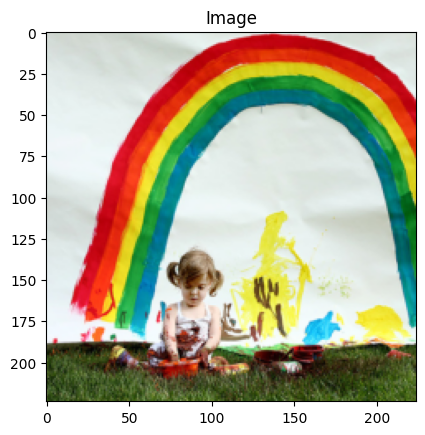

Token_ids: tensor([ 2,  4, 23, 18, 55,  6, 56, 57,  6, 58, 13,  4, 59, 60, 36, 27, 61,  6,
         4, 62, 17,  3])
Caption :
['<sos>', 'a', 'little', 'girl', 'covered', 'in', 'paint', 'sits', 'in', 'front', 'of', 'a', 'painted', 'rainbow', 'with', 'her', 'hands', 'in', 'a', 'bowl', '.', '<eos>']


In [45]:
img, ids = flickr_dataset[10]
display_image(img)
print('Token_ids:', ids)
print('Caption :')
print([flickr_dataset.vocab.get_itos()[token] for token in ids.tolist()])

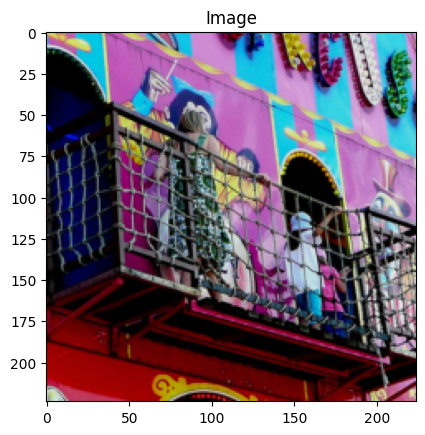

Token_ids: tensor([   2,    4,  187,   13,  188,  331,   39,    4, 1321,  124,    4,  535,
           0,   22,   17,    3])
Caption :
['<sos>', 'a', 'group', 'of', 'people', 'stand', 'on', 'a', 'balcony', 'near', 'a', 'colorful', '<unk>', 'building', '.', '<eos>']


In [46]:
img, ids = flickr_dataset[1500]
display_image(img)
print('Token_ids:', ids)
print('Caption :')
print([flickr_dataset.vocab.get_itos()[token] for token in ids.tolist()])

In [47]:
batch_size = 128

pad_idx = vocab['<pad>']

data_loader = DataLoader(
    dataset =  flickr_dataset,
    batch_size = batch_size,
    shuffle = True,
    collate_fn = generate_batch_captions(pad_idx = pad_idx, batch_first = True)
)

In [48]:
resnet = models.resnet50()

print(resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Dataloader is defined for the Dataset

Defining the Model Architecture.
Model is seq2seq model. In the encoder pretrained ResNet model is used to extract the features. Decoder, takes the encoder context as first input and generates the caption. In the decoder model LSTM cell is used.

Reference links for the  Seq2Seq Model-https://www.kaggle.com/code/mdteach/image-captioning-with-out-attention-pytorch

In [49]:
class EncoderCNN(nn.Module):

    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()

        resnet = models.resnet50(weights = models.ResNet50_Weights.DEFAULT)
        for param in resnet.parameters():
            param.requires_grad_(False)
        
        modules = list(resnet.children())[:-1]

        self.resnet = nn.Sequential(*modules)
        self.embed = nn.Linear(resnet.fc.in_features, embed_size)

    def forward(self, images):
        # Generates a feature representation of size 2048
        # features shape [batch_size, 2048, 1, 1]
        features = self.resnet(images)

        # [batch_size, 2048, 1, 1] -> [batch_size, 2048]
        features = features.view(features.size(0), -1)

        # [batch_size, 2048] -> [batch_size, emb_size]
        features = self.embed(features)

        return features

In [50]:
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers = 1):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embed_size)

        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers = num_layers, batch_first = True)
        
        self.fcn = nn.Linear(hidden_size, vocab_size)
        
   
    def forward(self, features, captions):

        # Captions shape [batch_size, longest_text_in_batch]
        # Embeddings shape [batch_size, longest_text_in_batch, embed_size] 
        # each word is represented using embedding of embed_size
        embeds = self.embedding(captions[:, :-1])

        # x shape [batch_size, longest_text_in_batch + 1, embedsize]
        # The first input to the decoder is the encoder output
        x = torch.cat((features.unsqueeze(1), embeds), dim = 1) 
        
        x, _ = self.lstm(x)
        x = self.fcn(x)

        return x
    
    def generate_caption(self, inputs, hidden = None, max_len = 20, vocab = None):
        
        batch_size = inputs.size(0)
        
        captions = []
        
        for i in range(max_len):
            
            output, hidden = self.lstm(inputs, hidden)
            output = self.fcn(output)
            output = output.view(batch_size, -1)
        
            predicted_word_idx = output.argmax(dim = 1)
            captions.append(predicted_word_idx.item())
            
            if vocab.get_itos()[predicted_word_idx.item()] == '<eos>':
                break

            inputs = self.embedding(predicted_word_idx.unsqueeze(0))
        
        return [vocab.get_itos()[idx] for idx in captions]


Image to Captions model is defined with both encoder and decoder(Without Attention)

In [51]:
class Image2Caption(nn.Module):
    def __init__(self, emb_size, hidden_size, vocab_size, num_layers = 1):
        super().__init__()

        self.encoder = EncoderCNN(emb_size)
        self.decoder = DecoderRNN(emb_size, hidden_size, vocab_size, num_layers)
    
    def forward(self, images, captions):
        
        features = self.encoder(images)
        outputs = self.decoder(features, captions)

        return outputs

Setting Hyperparameters for the model

In [52]:
emb_size = 300
hidden_size = 512
vocab_size = len(flickr_dataset.vocab)

num_layers = 2

learning_rate = 0.0001

Model is instantiatied with the hyperparameters. Also, Loss function and optimizers are defined.

In [53]:
model = Image2Caption(emb_size, hidden_size, vocab_size, num_layers)
model = model.to(device)

criterion = nn.CrossEntropyLoss(ignore_index = vocab['<pad>'])

optimizer = optim.Adam(model.parameters(), lr = learning_rate)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:02<00:00, 36.7MB/s]


Training is started with Model evaluation done at every 100 steps with Images with their predicted captions displayed.

In [ ]:
num_epochs = 10
print_every = 100

for epoch in range(1, num_epochs + 1):   
    for idx, (image, captions) in enumerate(iter(data_loader)):
        image, captions = image.to(device), captions.to(device)

        optimizer.zero_grad()
        outputs = model(image, captions)
        
        loss = criterion(outputs.view(-1, vocab_size), captions.view(-1))
        
        loss.backward()
        optimizer.step()

        if (idx + 1) % print_every == 0:
            print('Epoch: {} loss: {:.5f}'.format(epoch, loss.item()))

            model.eval()
            with torch.no_grad():
                img, _ = next(iter(data_loader))
                features = model.encoder(img[0:1].to(device))

                caps = model.decoder.generate_caption(features.unsqueeze(0), vocab = flickr_dataset.vocab)
                caption = ' '.join(caps)

                display_image(img[0], title = caption)
                
            model.train()
    
 